## Table of Contents:

* [Required Packages](#1)
* [Import Data](#2)
* [Visualizations](#3)
* [Normality Transformations](#4)
* [OLS Model](#5)
* [Model Diagnostics](#6)
* [Stationarity](#7)
* [ARIMAX Model Optimization](#8)
* [References](#9)

# Required Packages<a class="anchor" id="1"></a>

In [6]:
!pip install scipy
!pip install pmdarima

import datetime as dt
import logging
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.api as sm
import seaborn as sns
import scipy
import plotly.graph_objects as go
import warnings
import matplotlib.dates as mdates

from scipy.stats import mannwhitneyu
from scipy.stats import stats 
from pandas._libs.lib import dicts_to_array
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.api import qqplot
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro 
from scipy.stats import stats 

from scrapy import Selector
from bs4 import BeautifulSoup as Soup
from pandas._libs.lib import dicts_to_array
from binance.client import Client
from binance.cm_futures import CMFutures
from binance.lib.utils import config_logging
from binance.spot import Spot as Client
from statsmodels.formula.api import ols

warnings.filterwarnings('ignore')
%matplotlib inline

# Import Data<a class="anchor" id="2"></a>

In [7]:
btc_1h_df = pd.read_csv("/home/tolga/Desktop/1h_df.csv")
btc_1h_df["timestamp"] = pd.to_datetime(btc_1h_df["timestamp"])
btc_1h_df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 480 entries, 0 to 479

Data columns (total 11 columns):

 #   Column           Non-Null Count  Dtype         

---  ------           --------------  -----         

 0   timestamp        480 non-null    datetime64[ns]

 1   pair             480 non-null    object        

 2   longAccount      480 non-null    float64       

 3   shortAccount     480 non-null    float64       

 4   longShortRatio   480 non-null    float64       

 5   sumOpenInterest  480 non-null    int64         

 6   OI-%chg          480 non-null    float64       

 7   close            480 non-null    float64       

 8   volume           480 non-null    int64         

 9   symbol           480 non-null    object        

 10  fundingRate      480 non-null    float64       

dtypes: datetime64[ns](1), float64(6), int64(2), object(2)

memory usage: 41.4+ KB


In [8]:
btc_1h_df.index = btc_1h_df["timestamp"]

In [9]:
regression_df = btc_1h_df[["timestamp","longShortRatio","sumOpenInterest","close","volume","fundingRate"]]
regression_df

,timestamp,longShortRatio,sumOpenInterest,close,volume,fundingRate
timestamp,,,,,,
2022-12-08 09:00:00,2022-12-08 09:00:00,2.2884,3484383,16810.7,86389,-0.000005
2022-12-08 08:00:00,2022-12-08 08:00:00,2.3014,3493967,16830.1,113764,-0.000005
2022-12-08 07:00:00,2022-12-08 07:00:00,2.3014,3489069,16819.5,211793,-0.000005
2022-12-08 06:00:00,2022-12-08 06:00:00,2.2938,3480039,16798.7,150184,-0.000005
2022-12-08 05:00:00,2022-12-08 05:00:00,2.3058,3483545,16815.0,134970,-0.000005
...,...,...,...,...,...,...
2022-11-18 14:00:00,2022-11-18 14:00:00,2.4734,3021099,16675.6,561025,-0.000079
2022-11-18 13:00:00,2022-11-18 13:00:00,2.4868,3033003,16730.3,321808,-0.000079
2022-11-18 12:00:00,2022-11-18 12:00:00,2.4686,3035970,16752.5,175588,-0.000079


#  Visualizations<a class="anchor" id="3"></a>

<Figure size 1600x900 with 0 Axes>

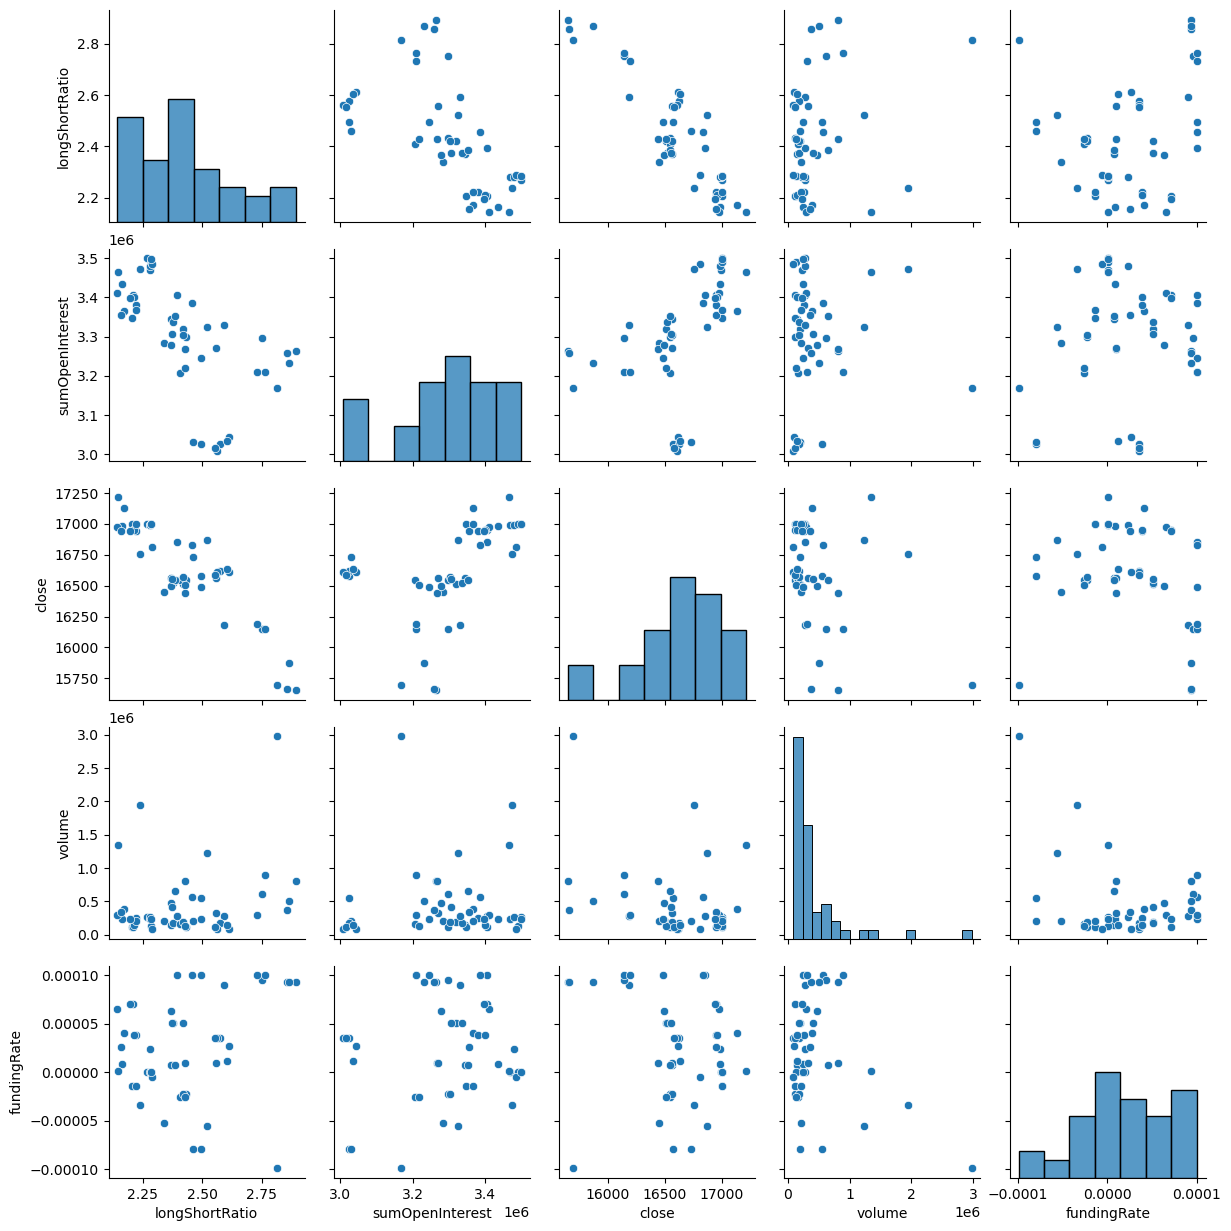

In [19]:
plt.figure(figsize=(16,9))
plt.suptitle('Pairplots of features', x=0.5, y=1.02, ha='center', fontsize='large')
sns.pairplot(regression_df.sample(50))
plt.show()

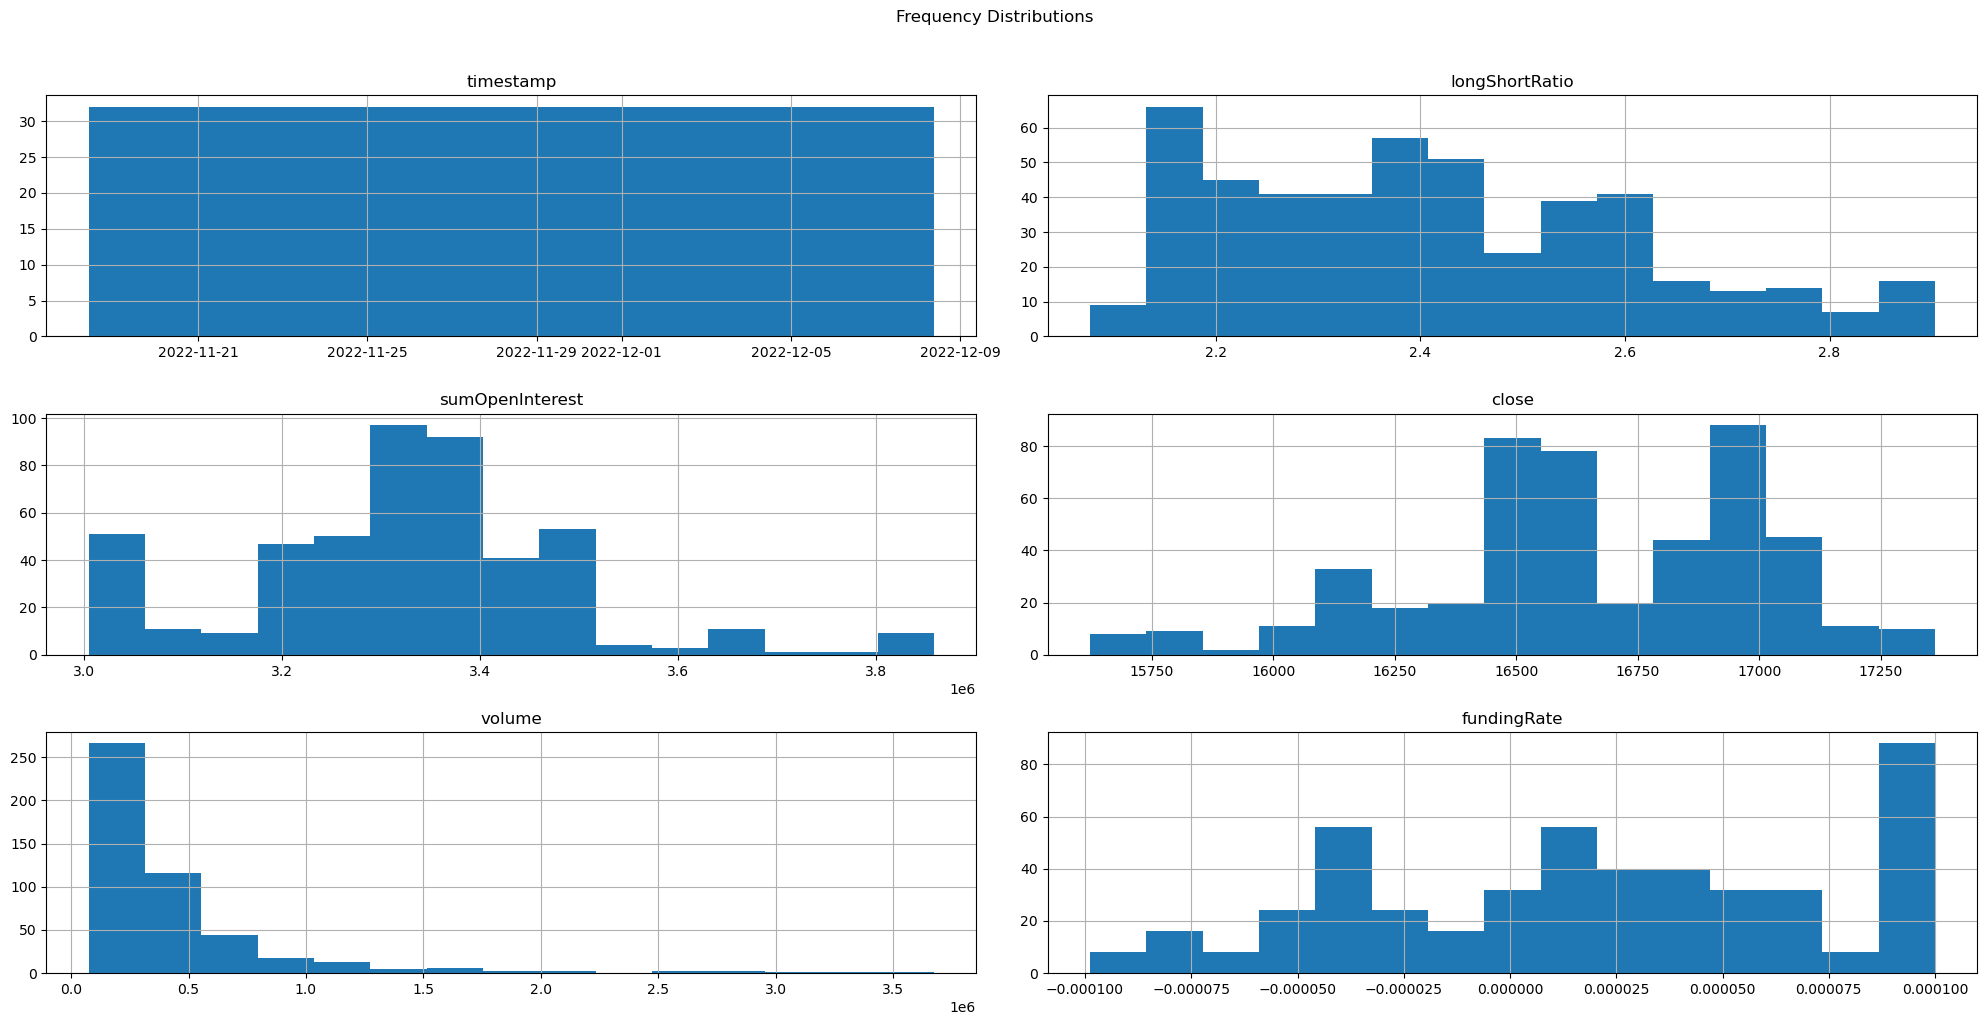

In [20]:
regression_df.hist(bins=15, figsize=(20,10))
plt.suptitle('Frequency Distributions', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

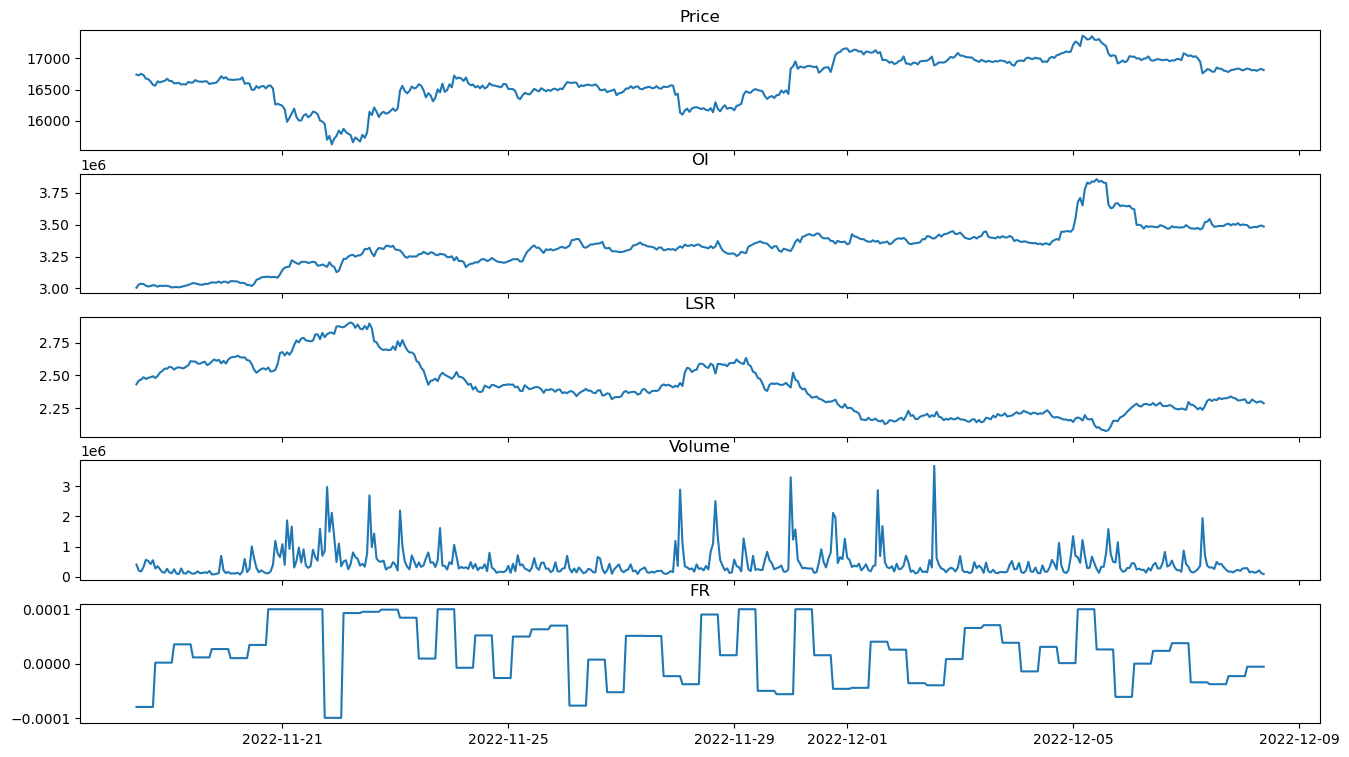

In [21]:
fig,ax = plt.subplots(5,1,sharex=True,figsize=(16,9))

ax[0].plot(regression_df["close"])
ax[1].plot(regression_df["sumOpenInterest"])
ax[2].plot(regression_df["longShortRatio"])
ax[3].plot(regression_df["volume"])
ax[4].plot(regression_df["fundingRate"])

ax[0].set_title("Price")
ax[1].set_title("OI")
ax[2].set_title("LSR")
ax[3].set_title("Volume")
ax[4].set_title("FR")


plt.show()

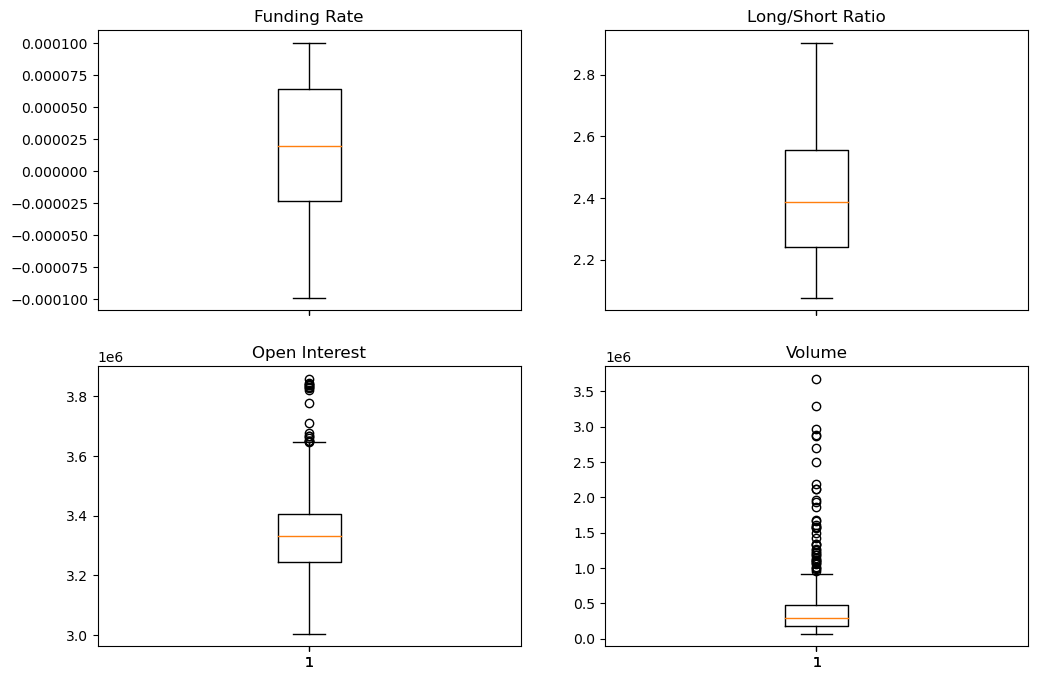

In [32]:
fig,ax=plt.subplots(2,2,figsize=(12,8),sharex=True)

ax[0,0].boxplot(regression_df["fundingRate"])
ax[0,1].boxplot(regression_df["longShortRatio"])
ax[1,0].boxplot(regression_df["sumOpenInterest"])
ax[1,1].boxplot(regression_df["volume"])

ax[0,0].set_title("Funding Rate")
ax[0,1].set_title("Long/Short Ratio")
ax[1,0].set_title("Open Interest")
ax[1,1].set_title("Volume")

plt.show()

IQR Method for omitting out the outliers

In [27]:
def remove_outlier(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

# Normality Transformations<a class="anchor" id="4"></a>

In [34]:
def transform_log(df):
    """does log transformation and 
    compares original vs transformed shapiro p-values"""
    from scipy.stats import shapiro 
    from scipy.stats import stats 
    dummy_df=[]
    
    for d in df:
        dummy_df = np.log(df)
        
    fig,axs = plt.subplots(nrows=1,ncols=2)
    axs[0].hist(df, edgecolor='black')
    axs[1].hist(dummy_df, edgecolor='black')
    axs[0].set_title('Original Data')
    axs[1].set_title('Log Transformed Data')
    plt.show()
    
    pvalue = shapiro(dummy_df)
    print(pvalue[1])

In [ ]:
def transform_sqrt(df):
    """does sqrt transformation and 
    compares original vs transformed shapiro p-values"""
    from scipy.stats import shapiro 
    from scipy.stats import stats     
    dummy_df=[]
    
    for d in df:
        dummy_df = np.sqrt(df)
        
    fig,axs = plt.subplots(nrows=1,ncols=2)
    axs[0].hist(df, edgecolor='black')
    axs[1].hist(dummy_df, edgecolor='black')
    axs[0].set_title('Original Data')
    axs[1].set_title('Square Root Transformed Data')
    plt.show()
    pvalue = shapiro(dummy_df)
    print(pvalue[1])

In [ ]:
def transform_cubic(df):
    """does cubic transformation and 
    compares original vs transformed shapiro p-values"""
    from scipy.stats import shapiro 
    from scipy.stats import stats     
    dummy_df=[]
    
    for d in df:
        dummy_df = np.cbrt(df)
        
    fig,axs = plt.subplots(nrows=1,ncols=2)
    axs[0].hist(df, edgecolor='black')
    axs[1].hist(dummy_df, edgecolor='black')
    axs[0].set_title('Original Data')
    axs[1].set_title('Cubic Transformed Data')
    plt.show()
    
    pvalue = shapiro(dummy_df)
    print(pvalue[1])

In [35]:
def transform_boxcox(df):
    """does boxcox transformation and 
    compares original vs transformed shapiro p-values"""
    from scipy.stats import shapiro 
    from scipy import stats     
    for d in df:
        fitted_data, lambda_data = stats.boxcox(df)
        
    fig,axs = plt.subplots(nrows=1,ncols=2)
    axs[0].hist(lambda_data, edgecolor='black')
    axs[1].hist(fitted_data, edgecolor='black')
    axs[0].set_title('Original Data')
    axs[1].set_title('Box Cox Transformed Data')
    plt.show()
    
    pvalue = shapiro(fitted_data)
    print(pvalue[1])

State the hypothesis

    When testing for normality:
    • Probabilities > 0.05 indicate that the data are normal.
    • Probabilities < 0.05 indicate that the data are
      
    Available transformation functions:
    - transform_boxcox(df)
    - transform_log(df)
    - transform_cubic(df)
    - transform_sqrt(df)
    
    
- If the data is normally distributed, Shapiro-Wilk p-value should be higher than 0.05, otherwise apply Kruskal-Willis for Non-Parametric (Not normally distributed) tests.


- For normally distributed variables, use pearson (stats.pearsonr) to find the correlation between variables.
  - stats.pearsonr

- For not normally distributed variables, use spearman (stats.spearmanr) to find the correlation between variables
  - stats.spearmanr

- By default, aforementioned functions contain Shapiro-Wilk tests, and the result will be printed at the end of the frequency distribution pairs 
  - stats.shapiro

- If variables are not normally distributed, apply Kruskal-Willis test (Parametric equivalent of ANOVA) ; 
  - stats.kruskal

Levene's test

In [5]:
def var_normality(df1,df2):
    levene_result = scipy.stats.levene(df1,df2,center="mean")
    print("\nP value of the Levene's test is " +  str(levene_result[1]))
    if levene_result[1]<0.05:
        print("\nVariances are not equal")
    else:
        print("\nVariances are equal")

Two-sample T test

In [2]:
def two_ttest(df1,df2):
    from scipy import stats
    t, pvalue = stats.ttest_ind(df1,df2)

    if pvalue < 0.05:
        print("\nHo is rejected")
        print("\npvalue : " + str(round(pvalue,3)))
    else:
        print("\npvalue : " + str(round(pvalue,3)))
        print("\nHo should be retained")

In [24]:
def is_normal(df):
    result = shapiro(df)
    if result[1] > 0.05:
        print("Normally Distributed")
    else:
        print("Not Normally Distributed")
    

In [26]:
is_normal(regression_df["volume"])

Not Normally Distributed


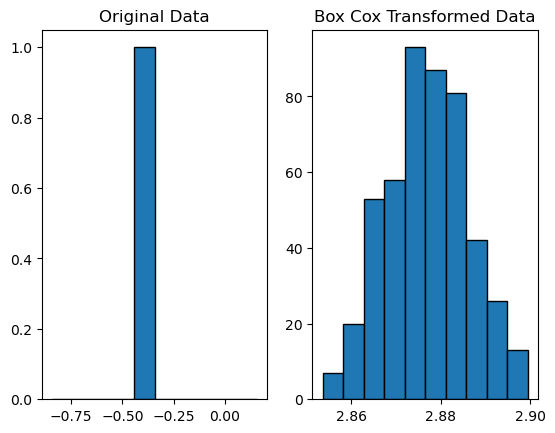

0.1450694501399994


In [36]:
transform_boxcox(regression_df["volume"])

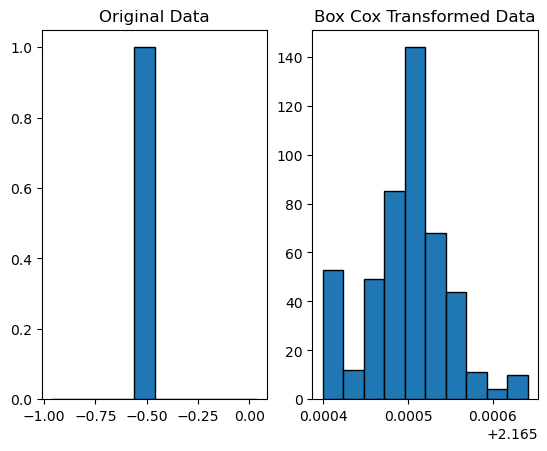

6.77423533934629e-11


In [37]:
transform_boxcox(regression_df["sumOpenInterest"])

# OLS Model <a class="anchor" id="5"></a>

In [3]:
def model_ols(y,x):
    """x = independent variable(s), 
      y=dependent variable"""
    from statsmodels.formula.api import ols
    import statsmodels.api as sm

    x = sm.add_constant(x)
    model = sm.OLS(y,x).fit()
    prediction = model.predict(x)
    return model.summary()

In [25]:
x = regression_df[["longShortRatio","sumOpenInterest","fundingRate"]]
y = regression_df["close"]
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            


Dep. Variable:                  close   R-squared:                       0.777

Model:                            OLS   Adj. R-squared:                  0.776

Method:                 Least Squares   F-statistic:                     553.6

Date:                Sat, 07 Jan 2023   Prob (F-statistic):          9.28e-155

Time:                        15:12:17   Log-Likelihood:                -3135.8

No. Observations:                 480   AIC:                             6280.

Df Residuals:                     476   BIC:                             6296.

Df Model:                           3                                         

Covariance Type:            nonrobust                                         


                      coef    std err          t      P>|t|      [0.025      0.975]

-----------------------------------------------------------------------------------

const            2.125e+04  

In [26]:
explanatory_data = pd.DataFrame(x)
prediction_data = explanatory_data.assign(Predicted_Price_btc=model.predict(explanatory_data))
prediction_data

,const,longShortRatio,sumOpenInterest,fundingRate,Predicted_Price_btc
timestamp,,,,,
2022-12-08 09:00:00,1.0,2.2884,3484383,-0.000005,16816.388743
2022-12-08 08:00:00,1.0,2.3014,3493967,-0.000005,16792.903205
2022-12-08 07:00:00,1.0,2.3014,3489069,-0.000005,16793.705276
2022-12-08 06:00:00,1.0,2.2938,3480039,-0.000005,16807.996478
2022-12-08 05:00:00,1.0,2.3058,3483545,-0.000005,16787.192096
...,...,...,...,...,...
2022-11-18 14:00:00,1.0,2.4734,3021099,-0.000079,16554.431003
2022-11-18 13:00:00,1.0,2.4868,3033003,-0.000079,16529.891212
2022-11-18 12:00:00,1.0,2.4686,3035970,-0.000079,16560.087909


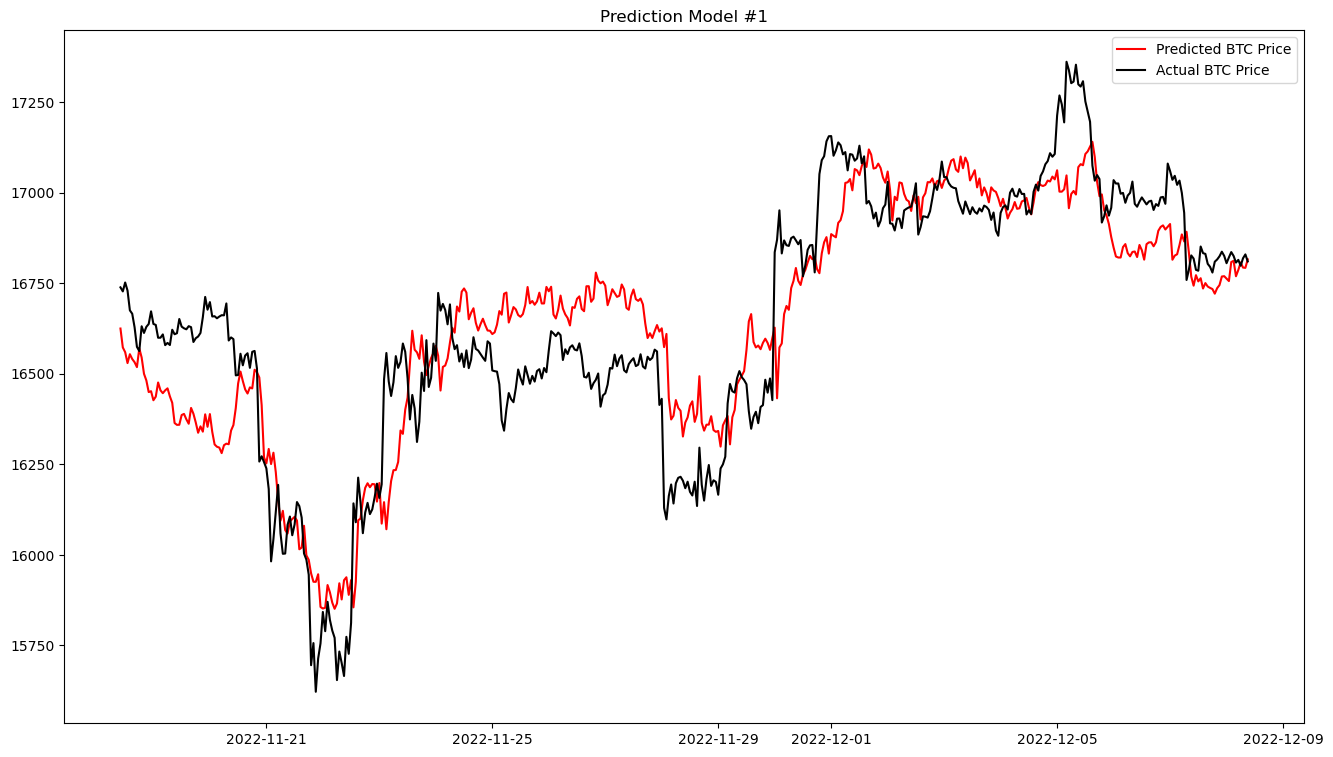

In [27]:
fig, ax = plt.subplots(sharex=True,sharey=True,figsize=(16,9))

ax.plot(regression_df.index,prediction_data["Predicted_Price_btc"],label="Predicted BTC Price",color="red")
ax.plot(regression_df.index,regression_df["close"],label="Actual BTC Price",color="black")
ax.legend()
plt.title("Prediction Model #1")
plt.show()

# Model Diagnostics <a class="anchor" id="6"></a>

In [14]:
def qq(ols_df):
    
    from statsmodels.api import qqplot
    sm.qqplot(data=ols_df.resid, fit=True,line="45")
    plt.show()

    This assumes that there is a linear relationship between the predictors (e.g. independent variables or features) and the response variable (e.g. dependent variable or label). This also assumes that the predictors are additive.
    
    After building an OLS model, use the following function to find the Q-Q plot of the model to resolve whether Model is a good fit or not

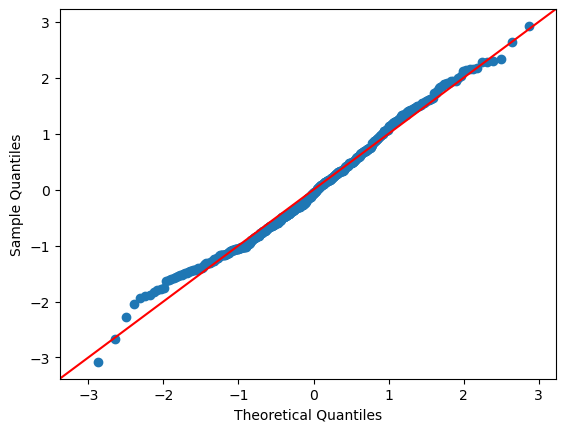

In [28]:
qq(model)

    Apply frequency distribution on the residual values of the OLS model. 

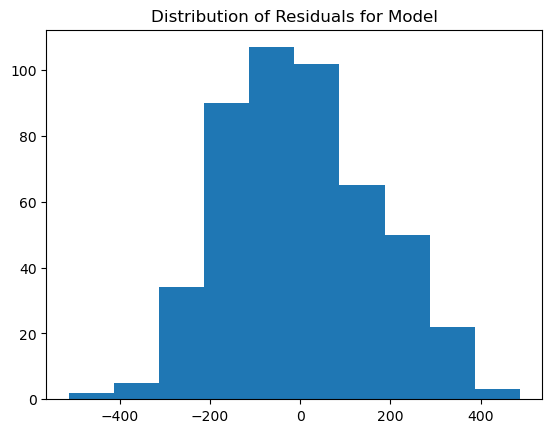

ShapiroResult(statistic=0.9897397756576538, pvalue=0.0019620852544903755)

In [29]:
plt.hist(x=model.resid)
plt.title("Distribution of Residuals for Model")
plt.show()
shapiro(model.resid)

# Stationarity <a class="anchor" id="7"></a>

In [4]:
def adf_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

   For Parametric Tests
    
    Augmented Dickey-Fuller (ADF) test is a unit root test that tests the null hypothesis that α=1 in the following model equation. alpha is the coefficient of the first lag on Y.

   - Ho: Series is non-stationary or series has a unit root
   - Ha: Series is stationary or series has no unit rot

In [5]:
def kpss_test(timeseries):
    from statsmodels.tsa.stattools import kpss
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

   For Non-Parametric Tests
    
    Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

   - Ho: Series is trend stationary or series has no unit root.

   - Ha: Series is non-stationary or series has a unit root.
   
       Conditions to Fail to Reject Null Hypothesis(HO)

    If, Test statistic < Critical Value & p-value < 0.05, you must fail to Reject Null Hypothesis (Ho) i.e., time series does not have a unit root, meaning it is trend stationary.
    
    Note: Hypothesis is reversed in KPSS test compared to ADF Test.

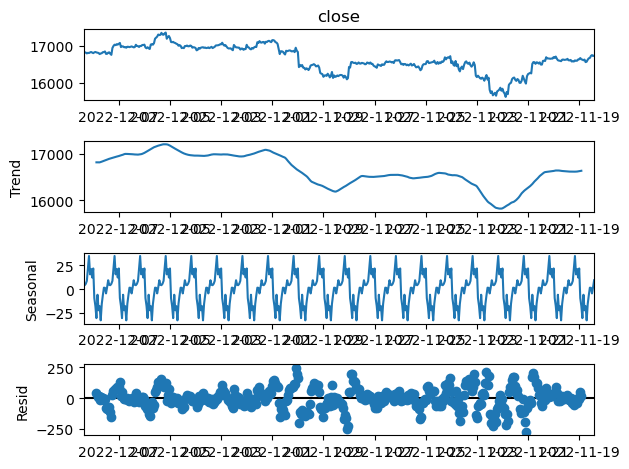

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(regression_df["close"],model="additive")
sd.plot()
plt.show()

# ARIMAX Model Optimization<a class="anchor" id="8"></a>

PACF & ACF (AR|MA Model determination)

The Akaike information criterion, or AIC, is a metric which tells us how 
good a model is. A model which makes better predictions is given a lower AIC score.

The AIC also penalizes models which have lots of parameters. This means if we set the order too high compared to the data, we will get a high AIC value. This stops us overfitting to the training data.

The Bayesian information criterion, or BIC, is very similar to the AIC. Models which fit the data better have lower BICs and the BIC penalizes overly complex models.

An ARIMA model is delineated by three terms: p, d, q where,

    p is a particular order of the AR term
    q is a specific order of the MA term
    d is the number of differences wanted to make the time series stationary


In [15]:
def plot_arma(df):
    plot_acf(df)
    plot_pacf(df)
    plt.show()

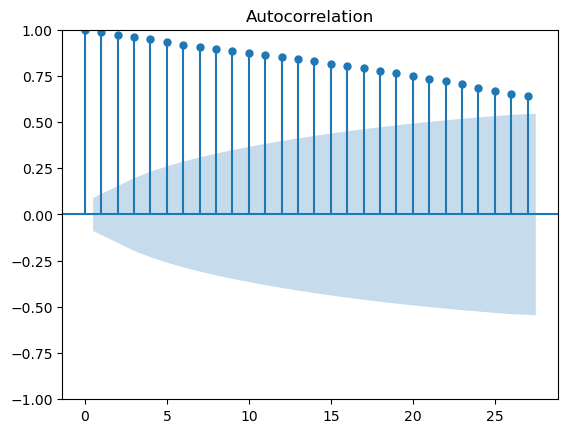

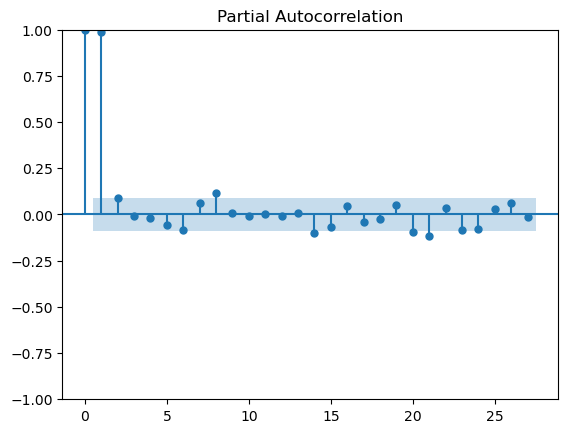

In [16]:
plot_arma(regression_df["close"])

In [1]:
def opt_arimax(df1,df2):
    """ df2 should be used only when there is 
    exogeneous variables within the data"""
    results = pm.auto_arima(df1,
                         df2,
                         d=2,
                         start_p=1,
                         start_q=1,
                         max_p=10,
                         max_q=10,
                         information_criterion="aic",
                         trace=True,
                         error_action="ignore")
    return results

In [73]:
def automate_arimax(df1,df2):
    order_aic_bic=[]
    for p in range(3):
        for i in range(1,3):
            for q in range(3):
                model = ARIMA(df1, order=(p,i,q),exog=df2)
                results = model.fit()

                order_aic_bic.append(((p,i,q,),results.aic,results.bic))

    order_aic_bic = pd.DataFrame(order_aic_bic,columns=[("p","i","q"),"aic","bic"])
    print(order_aic_bic.sort_values(by="aic",ascending=False).head(15))

In [74]:
automate_arimax(regression_df["close"],regression_df["volume"])

    (p, i, q)          aic          bic

3   (0, 2, 0)  8105.806946  8114.146167

0   (0, 1, 0)  7752.575649  7760.919050

9   (1, 2, 0)  5470.962712  5483.471544

15  (2, 2, 0)  5407.888318  5424.566761

10  (1, 2, 1)  5326.746393  5343.424836

16  (2, 2, 1)  5325.983124  5346.831178

4   (0, 2, 1)  5316.665232  5329.174064

17  (2, 2, 2)  5315.084080  5340.101744

5   (0, 2, 2)  5309.173635  5325.852078

11  (1, 2, 2)  5307.925381  5328.773435

14  (2, 1, 2)  5282.331639  5307.361843

8   (1, 1, 2)  5280.332306  5301.190809

13  (2, 1, 1)  5280.331127  5301.189630

2   (0, 1, 2)  5275.097398  5291.784200

7   (1, 1, 1)  5275.064790  5291.751593


In [67]:
def model_arimax(df1,df2,start,steps,exog_step):
   
    """models arima accordingly the given p,i,q and
    plots diagnostics of the model residuals.Start,steps and 
    exog_step values should be negative (eg: if given -30, it starts 
    predicting from the last 30 obsv)"""
    
    # builds the arima model
    model = ARIMA(df1,order=(1,3,1),exog=df2)
    results = model.fit()
    print(results.summary())
    
    # plots model diagnostics
    results.plot_diagnostics(figsize=(16,8))
        
    # fitting process begins
    forecast = results.get_prediction(start=start)
    mean_forecast = forecast.predicted_mean
    
    # starts forecasting
    """ the steps value and the exog values should match 
    in terms of where the prediction begins at"""
    
    forecast2 = results.get_forecast(steps=steps,exog=df2.iloc[exog_step:])
    mean_forecast2 = forecast2.predicted_mean
    confidence_intervals2 = forecast2.conf_int()
    
    # plots the forecasted timeseries
    fig,ax=plt.subplots()
    
    plt.plot(mean_forecast2.index,
             mean_forecast2.values,
             color="black",
             label="forecasted") 

    plt.show()

If the JB p-value is zero, which means you should reject the null hypothesis that the residuals are normally distributed. However, the histogram and Q-Q plots may show that the residuals look normal. In this case, you could go back and apply some transformation to remove the outliers or you probably just continue to the production stage.

                               SARIMAX Results                                


Dep. Variable:                  close   No. Observations:                  480

Model:                 ARIMA(1, 3, 1)   Log Likelihood               -2768.199

Date:                Sun, 15 Jan 2023   AIC                           5544.398

Time:                        18:22:41   BIC                           5561.068

Sample:                             0   HQIC                          5550.953

                                - 480                                         

Covariance Type:                  opg                                         


                 coef    std err          z      P>|z|      [0.025      0.975]

------------------------------------------------------------------------------

volume     -4.414e-06   2.43e-06     -1.819      0.069   -9.17e-06    3.43e-07

ar.L1         -0.3300      0.040     -8.223      0.000      -0.409      -0.251

ma.L1         -0.9228      0.045    -2

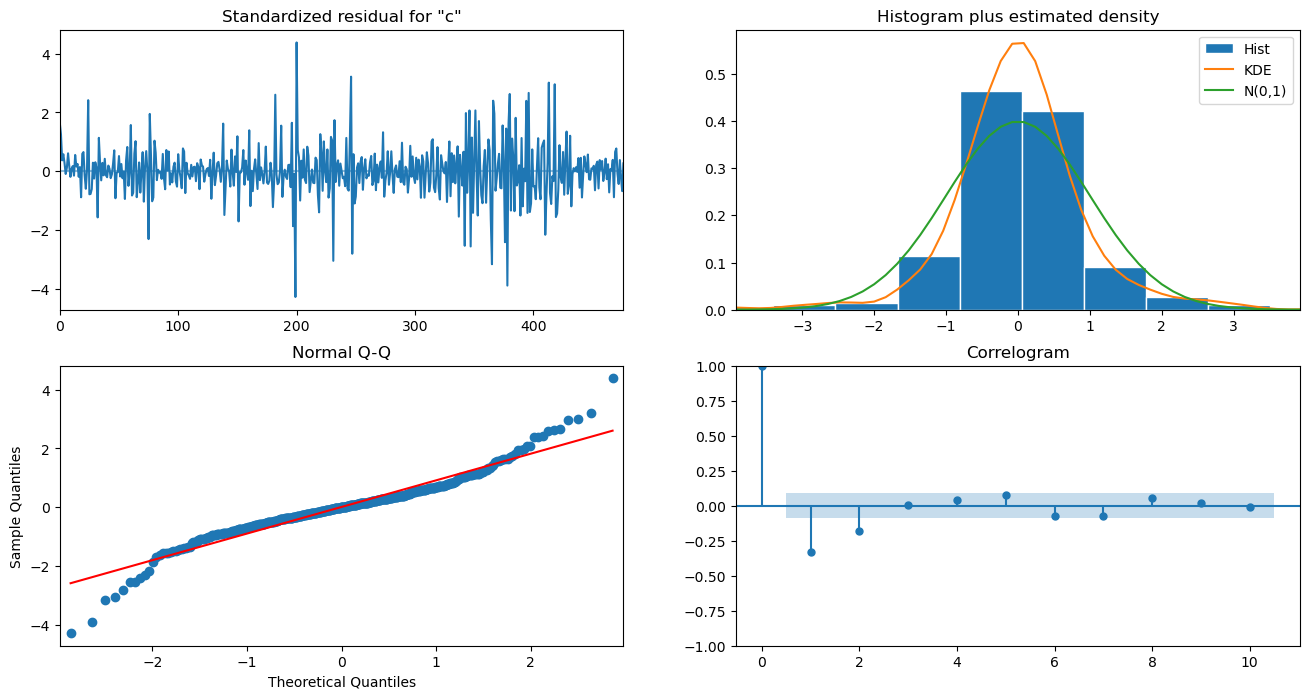

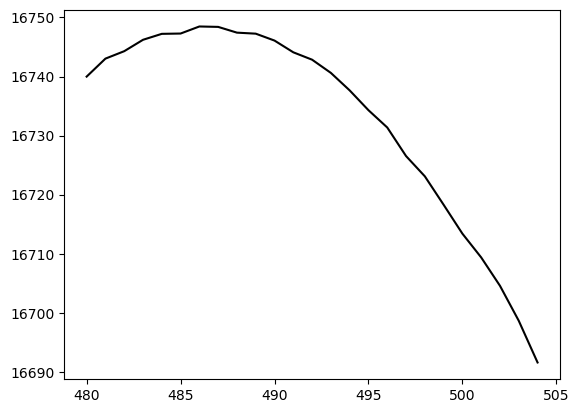

In [70]:
model_arimax(regression_df["close"],regression_df["volume"],150,25,-25)

# References <a class="anchor" id="9"></a>

* https://pythonhosted.org/PyQt-Fit/NonParam_tut.html 
* https://towardsdatascience.com/anova-t-test-and-other-statistical-tests-with-python-e7a36a2fdc0c 
* https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/
* https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
* https://towardsdatascience.com/non-parametric-tests-in-hypothesis-testing-138d585c3548
* Datacamp
 